
# Deep Learning Approach at Classifying Valence of a Song Based off its Lyrics



## Importing Code and Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision import models
import nltk
import gensim
from gensim.models import Word2Vec


## Importing Data

data was located in a csv file. For this project, only the lyrics will be used to find a relation with the binary valence variable denoting if a song is happy or sad.

In [3]:
df = pd.read_csv('./drive/MyDrive/NLPproject/data_bin.csv')
df

,Unnamed: 0,Unnamed: 0.1,lastfm_url,track,artist,seeds,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,mbid,spotify_id,genre,lyrics,binary_valence
0,0,2949,https://www.last.fm/music/skywave/_/another%2b...,Another Love,Skywave,"['explosive', 'euphoric']",5,5.440000,4.582000,4.548000,3eba75ff-50d1-48eb-b39f-2e1e456c0847,NaN,shoegaze,"[Intro]\r\nIt's Rittz, bitch\r\n\r\n[Verse 1]\...",1
1,1,65958,https://www.last.fm/music/neneh%2bcherry/_/pea...,Peace In Mind,Neneh Cherry,['reflective'],4,4.841667,2.815000,4.950000,05011436-be05-433d-b7d1-405f14b45838,3qij053VLKWDprTlF6REDl,trip-hop,I've got a little piece of mind\r\nFrom the co...,0
2,2,43234,https://www.last.fm/music/adam%2bgreen/_/goblin,Goblin,Adam Green,['silly'],1,6.720000,4.860000,6.500000,93f50361-0581-4dd6-a294-93ca5bef904f,122tMrH7PcUWMN4AcklyU0,folk,When she stopped talking to me\r\nI knew that ...,1
3,3,5766,https://www.last.fm/music/ceremony/_/i%2bwant%...,I Want To Put This To An End,Ceremony,['intense'],2,3.995000,6.135000,4.585000,3b09dada-b877-4bda-b35a-34a1d28b1461,3HBwKXoQnPdi8Tzmioiwyv,hardcore,"My heart beats in slow songs, pumping moments ...",0
4,4,61410,https://www.last.fm/music/beyond%2bcreation/_/...,Coexistence,Beyond Creation,['technical'],2,5.693333,5.476275,6.390392,e4348ebc-97f2-4bcb-af2e-2998d0fae905,3TfnNa2rOCuGZi4IBWtYVE,technical death metal,When the universal darkness is covering the ea...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,5995,89595,https://www.last.fm/music/diane%2bbirch/_/noth...,Nothing But A Miracle,Diane Birch,['quiet'],6,6.062000,3.772000,5.639000,db1d9721-6dd4-40b5-89a2-42562e94086e,6IZVRuDF1R3vu7M7x6jAkM,soul,Gettin' tired of livin'\r\nLivin' for a moment...,1
5996,5996,25650,https://www.last.fm/music/tran%2bqual/_/montse...,Montserrat,Tran Qual,['relaxed'],9,5.326474,3.281561,5.053699,NaN,NaN,indie,None,1
5997,5997,28401,https://www.last.fm/music/raging%2bslab/_/here...,Here Lies,Raging Slab,"['sarcastic', 'sardonic', 'cynical']",4,2.742500,3.395000,3.935000,dc3b6de4-e085-4f36-a848-d42f4b405f36,NaN,rock,None,0
5998,5998,83488,https://www.last.fm/music/jurassic%2b5/_/back%...,Back 4 You,Jurassic 5,['confident'],2,7.386102,4.336271,6.921017,444318b7-ae48-4dde-a45c-ab3460faeb35,NaN,hip-hop,"[Intro: Soup]\r\nCheck this out, real quick\r\...",1


In [4]:
toDrop = df.index[df["lyrics"] == 'None'].tolist()
print(toDrop)
df.drop(toDrop, axis = 0, inplace = True)
print(df.index[df["lyrics"] =='None'].tolist())

[5, 6, 10, 11, 13, 14, 15, 17, 19, 20, 21, 25, 26, 31, 42, 47, 48, 50, 52, 61, 62, 68, 69, 74, 76, 85, 107, 108, 116, 117, 123, 129, 132, 133, 135, 136, 138, 141, 145, 148, 158, 161, 162, 163, 166, 167, 173, 180, 181, 186, 187, 189, 190, 198, 199, 200, 202, 203, 204, 206, 210, 212, 214, 215, 218, 219, 221, 222, 230, 232, 235, 236, 240, 241, 247, 249, 250, 254, 255, 258, 259, 261, 264, 268, 275, 277, 278, 279, 281, 285, 287, 290, 291, 293, 295, 297, 306, 309, 314, 330, 333, 334, 335, 336, 337, 343, 345, 347, 348, 351, 353, 355, 357, 358, 359, 361, 365, 366, 372, 374, 376, 377, 382, 385, 386, 388, 395, 402, 404, 405, 406, 407, 408, 410, 412, 413, 418, 422, 425, 428, 430, 440, 449, 451, 452, 456, 457, 459, 460, 462, 464, 466, 468, 475, 476, 477, 480, 483, 486, 487, 491, 495, 506, 516, 518, 520, 524, 526, 527, 530, 537, 539, 544, 546, 548, 549, 553, 555, 556, 560, 561, 562, 564, 566, 569, 570, 571, 572, 574, 575, 576, 579, 583, 584, 587, 591, 596, 598, 606, 609, 610, 611, 613, 614, 617, 62

In [5]:
y = df['binary_valence'].to_numpy()
X = df['lyrics'].to_numpy()


In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Tokenizing and Embeedding

the data was tokenized using nltk and then, using googles pretrained word2vec model, was converted into word embeddings to better be able to classify the data. 

In [7]:
delete_list = ['Intro','Verse','Hook']
X_tokenized = []
for lyrics in X:
  sent_tok = nltk.sent_tokenize(lyrics)
  word_tok = [nltk.word_tokenize(i) for i in sent_tok]
  word_tok = [word.lower() for sublist in word_tok for word in sublist if (word.isalpha() and word not in delete_list)]
  X_tokenized.append(word_tok)

In [8]:
bigmodel = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/NLPproject/GoogleNews-vectors-negative300-SLIM.bin.gz', binary=True)


In [9]:
song_vecs = []

for toks in X_tokenized:
  totvec = np.zeros(300)
  for tok in toks:
    if tok.lower() in bigmodel:
      totvec += bigmodel[tok.lower()]
  song_vecs.append(totvec)

print(len(song_vecs))
print(len(song_vecs[0]))

4111
300


## Getting Word Embedding Data Ready for Model

In order to have an efficient way of training and testing, the data was first shuffled and then divided in an 80-20 split (training-testing). Afterwards, the data was then supplied into a DataLoader object for proper interaction with the pytorch model later on.

In [10]:
indexes = np.array(range(len(y)))
np.random.shuffle(indexes)
indexes
print(np.array(song_vecs).shape, np.array(y).shape)

(4111, 300) (4111,)


In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
song_vecs = sc.fit_transform(song_vecs)

In [12]:
song_vecs.shape

(4111, 300)

In [13]:
y_shuffled = []
X_shuffled = []
dataset = []
shuffled_dataset = []
for i in range(len(y)):
  dataset.append((torch.tensor(song_vecs[i], dtype = torch.float32),torch.tensor(y[i], dtype = torch.float32)))
for i in range(len(dataset)):
  shuffled_dataset.append(dataset[indexes[i]])
  X_shuffled.append(song_vecs[indexes[i]])
  y_shuffled.append(y[indexes[i]])

train_set = dataset[0:int(len(shuffled_dataset) * .8)]
test_set = dataset[int(len(shuffled_dataset) * .8):]
X_test = X_shuffled[int(len(shuffled_dataset) * .8):]
y_test = y_shuffled[int(len(shuffled_dataset) * .8):]
print(len(X_test),len(test_set),len(y_test))

823 823 823


In [14]:
trainset = torch.utils.data.DataLoader(train_set,batch_size = 20, shuffle = True, num_workers = 2)
testset = torch.utils.data.DataLoader(test_set,batch_size = 20, shuffle = False, num_workers = 2)
classes = ('sad','happy')

for images, labels in trainset:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([20, 300])
torch.Size([20])


In [15]:
class Net(nn.Module):
  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape,32)
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64,1)
  
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

In [16]:
x_test = torch.tensor(np.array(X_test), dtype = torch.float32)
y_test = torch.tensor(np.array(y_test), dtype = torch.float32)

In [39]:
learning_rate = 0.01
epochs = 200
# Model , Optimizer, Loss
model = Net(input_shape=x_test.shape[1])
device = torch.device('cuda')
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [18]:
x_test = x_test.to(device)
y_test = y_test.to(device) 

In [40]:
losses = []
accur = []
f1 = []
model.eval()
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(trainset):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    #calculate output
    output = model(x_train)
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
    #accuracy
    predicted = model(x_test)
    comparer1 = predicted.cpu().reshape(-1).detach().numpy().round()
    comparer2 = y_test.cpu().numpy()
    true_pos = [v for v in range(len(comparer1)) if comparer1[v] == 1 and comparer1[v] == comparer2[v]]
    false_pos = [v for v in range(len(comparer1)) if comparer1[v] == 1 and comparer1[v] != comparer2[v]]
    false_neg = [v for v in range(len(comparer1)) if comparer1[v] == 0 and comparer1[v] != comparer2[v]]
    true_neg = [v for v in range(len(comparer1)) if comparer1[v] == 0 and comparer1[v] == comparer2[v]]
    acc = (len(true_pos) + len(true_neg))/(len(true_pos) + len(true_neg) + len(false_pos) + len(false_neg))
    recall = len(true_pos) /(len(true_pos) + len(false_pos))
    precision = len(true_pos) / (len(true_pos) + len(false_pos))
    f1_score = (2 * precision * recall) / (precision + recall)
    #backprop
    optimizer.zero_grad()
    loss.backward()
    loss.detach()
    x_train.detach()
    y_train.detach()
    optimizer.step()
  losses.append(loss.cpu().detach())
  accur.append(acc)
  f1.append(f1_score)
  if i % 50 == 0:
    print("epoch {}\tloss : {}\t accuracy : {} \t f1 score: {}".format(i,loss,acc,f1_score))

epoch 0	loss : 0.69789719581604	 accuracy : 0.6816524908869988 	 f1 score: 0.6816524908869988
epoch 50	loss : 0.5008966326713562	 accuracy : 0.7035236938031592 	 f1 score: 0.7144790257104194
epoch 100	loss : 0.3933359384536743	 accuracy : 0.7606318347509113 	 f1 score: 0.7879746835443038
epoch 150	loss : 0.17156952619552612	 accuracy : 0.8335358444714459 	 f1 score: 0.9124513618677043


In [42]:
print('A Loss of {}, an Accuracy of {} and an f1 score of {} After 200 Epochs'.format(round(float(losses[-1]),3),round(accur[-1],3), round(f1[-1],3)))

A Loss of 0.097, an Accuracy of 0.878 and an f1 score of 0.905 After 200 Epochs


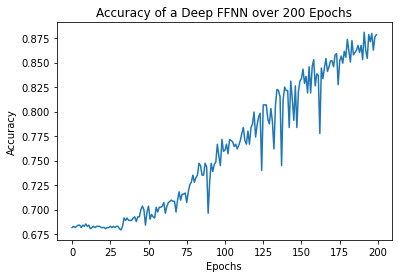

In [43]:
plt.plot(range(0,200), accur)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of a Deep FFNN over 200 Epochs')
plt.show()

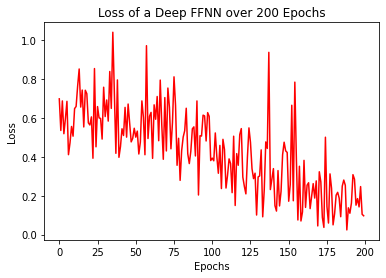

In [52]:
plt.plot(range(0,200), losses, color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss of a Deep FFNN over 200 Epochs')
plt.show()

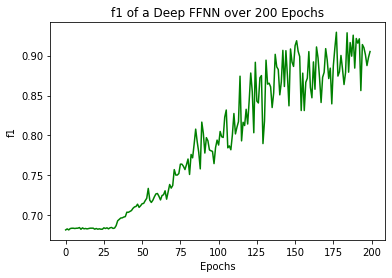

In [53]:
plt.plot(range(0,200), f1, color = 'green')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.title('f1 of a Deep FFNN over 200 Epochs')
plt.show()

In [47]:
torch.save(model.state_dict(),'./drive/MyDrive/NLPproject/FFNN')

In [50]:
class DropNet(nn.Module):
  def __init__(self,input_shape):
    super(DropNet,self).__init__()
    self.fc1 = nn.Linear(input_shape,32)
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64,128)
    self.fc4 = nn.Linear(128, 256)
    self.fc5 = nn.Linear(256,1)
    self.dropout = nn.Dropout(0.01)
  
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = self.dropout(x)
    x = torch.sigmoid(self.fc5(x))
    return x

In [51]:
learning_rate = 0.01
epochs = 200
# Model , Optimizer, Loss
model = DropNet(input_shape=x_test.shape[1])
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [54]:
losses = []
accur = []
f1 = []
model.eval()
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(trainset):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    #calculate output
    output = model(x_train)
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
    #accuracy
    predicted = model(x_test)
    comparer1 = predicted.cpu().reshape(-1).detach().numpy().round()
    comparer2 = y_test.cpu().numpy()
    true_pos = [v for v in range(len(comparer1)) if comparer1[v] == 1 and comparer1[v] == comparer2[v]]
    false_pos = [v for v in range(len(comparer1)) if comparer1[v] == 1 and comparer1[v] != comparer2[v]]
    false_neg = [v for v in range(len(comparer1)) if comparer1[v] == 0 and comparer1[v] != comparer2[v]]
    true_neg = [v for v in range(len(comparer1)) if comparer1[v] == 0 and comparer1[v] == comparer2[v]]
    acc = (len(true_pos) + len(true_neg))/(len(true_pos) + len(true_neg) + len(false_pos) + len(false_neg))
    recall = len(true_pos) /(len(true_pos) + len(false_pos))
    precision = len(true_pos) / (len(true_pos) + len(false_pos))
    f1_score = (2 * precision * recall) / (precision + recall)
    #backprop
    optimizer.zero_grad()
    loss.backward()
    loss.detach()
    x_train.detach()
    y_train.detach()
    optimizer.step()
  losses.append(loss.cpu().detach())
  accur.append(acc)
  f1.append(f1_score)
  if i % 50 == 0:
    print("epoch {}\tloss : {}\t accuracy : {} \t f1 score: {}".format(i,loss,acc,f1_score))

epoch 0	loss : 0.660832405090332	 accuracy : 0.6816524908869988 	 f1 score: 0.6816524908869988
epoch 50	loss : 0.462767094373703	 accuracy : 0.6962332928311057 	 f1 score: 0.7224606580829757
epoch 100	loss : 0.22376027703285217	 accuracy : 0.8493317132442284 	 f1 score: 0.8541329011345219
epoch 150	loss : 0.00904602836817503	 accuracy : 0.8833535844471446 	 f1 score: 0.9015544041450776


In [55]:
print('A Loss of {}, an Accuracy of {} and an f1 score of {} After 200 Epochs'.format(round(float(losses[-1]),3),round(accur[-1],3), round(f1[-1],3)))

A Loss of 0.233, an Accuracy of 0.878 and an f1 score of 0.929 After 200 Epochs


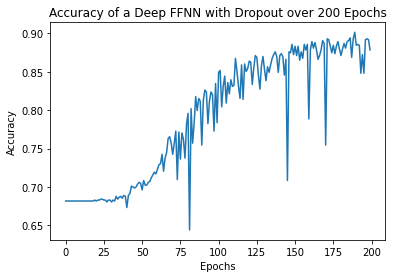

In [57]:
plt.plot(range(0,200), accur)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of a Deep FFNN with Dropout over 200 Epochs')
plt.show()

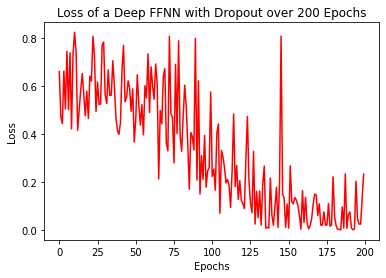

In [56]:
plt.plot(range(0,200), losses, color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss of a Deep FFNN with Dropout over 200 Epochs')
plt.show()

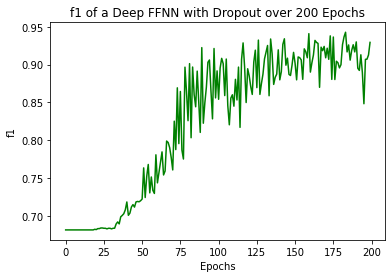

In [58]:
plt.plot(range(0,200), f1, color = 'green')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.title('f1 of a Deep FFNN with Dropout over 200 Epochs')
plt.show()

In [59]:
torch.save(model.state_dict(),'./drive/MyDrive/NLPproject/DropoutFFNN')

In [60]:
class DeepBatchNormNet(nn.Module):
  def __init__(self,input_shape):
    super(DeepBatchNormNet,self).__init__()
    self.fc1 = nn.Linear(input_shape,32)
    self.b1 = nn.BatchNorm1d(32)
    self.fc2 = nn.Linear(32,64)
    self.b2 = nn.BatchNorm1d(64)
    self.fc3 = nn.Linear(64,128)
    self.b3 = nn.BatchNorm1d(128)
    self.fc4 = nn.Linear(128, 256)
    self.b4 = nn.BatchNorm1d(256)
    self.fc5 = nn.Linear(256,1)
    self.dropout = nn.Dropout(0.01)
  
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = self.b1(x)
    x = torch.relu(self.fc2(x))
    x = self.b2(x)
    x = torch.relu(self.fc3(x))
    x = self.b3(x)
    x = torch.relu(self.fc4(x))
    x = self.b4(x)
    x = self.dropout(x)
    x = torch.sigmoid(self.fc5(x))
    return x

In [61]:
learning_rate = 0.01
epochs = 200
# Model , Optimizer, Loss
model = DeepBatchNormNet(input_shape=x_test.shape[1])
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [62]:
losses = []
accur = []
f1 = []
model.eval()
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(trainset):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    #calculate output
    output = model(x_train)
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
    #accuracy
    predicted = model(x_test)
    comparer1 = predicted.cpu().reshape(-1).detach().numpy().round()
    comparer2 = y_test.cpu().numpy()
    true_pos = [v for v in range(len(comparer1)) if comparer1[v] == 1 and comparer1[v] == comparer2[v]]
    false_pos = [v for v in range(len(comparer1)) if comparer1[v] == 1 and comparer1[v] != comparer2[v]]
    false_neg = [v for v in range(len(comparer1)) if comparer1[v] == 0 and comparer1[v] != comparer2[v]]
    true_neg = [v for v in range(len(comparer1)) if comparer1[v] == 0 and comparer1[v] == comparer2[v]]
    acc = (len(true_pos) + len(true_neg))/(len(true_pos) + len(true_neg) + len(false_pos) + len(false_neg))
    recall = len(true_pos) /(len(true_pos) + len(false_pos))
    precision = len(true_pos) / (len(true_pos) + len(false_pos))
    f1_score = (2 * precision * recall) / (precision + recall)
    #backprop
    optimizer.zero_grad()
    loss.backward()
    loss.detach()
    x_train.detach()
    y_train.detach()
    optimizer.step()
  losses.append(loss.cpu().detach())
  accur.append(acc)
  f1.append(f1_score)
  if i % 50 == 0:
    print("epoch {}\tloss : {}\t accuracy : {} \t f1 score: {}".format(i,loss,acc,f1_score))

epoch 0	loss : 0.6192989945411682	 accuracy : 0.6816524908869988 	 f1 score: 0.6816524908869988
epoch 50	loss : 0.6328072547912598	 accuracy : 0.6865127582017011 	 f1 score: 0.7022696929238985
epoch 100	loss : 0.3781789541244507	 accuracy : 0.7922235722964763 	 f1 score: 0.8175895765472313
epoch 150	loss : 0.17613080143928528	 accuracy : 0.8699878493317132 	 f1 score: 0.9053571428571429


In [63]:
print('A Loss of {}, an Accuracy of {} and an f1 score of {} After 200 Epochs'.format(round(float(losses[-1]),3),round(accur[-1],3), round(f1[-1],3)))

A Loss of 0.005, an Accuracy of 0.897 and an f1 score of 0.913 After 200 Epochs


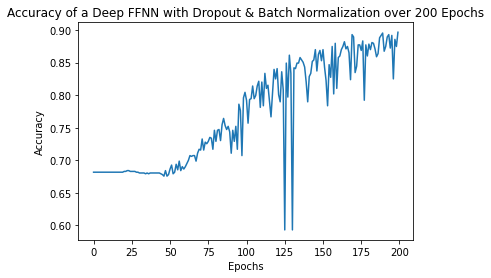

In [64]:
plt.plot(range(0,200), accur)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of a Deep FFNN with Dropout & Batch Normalization over 200 Epochs')
plt.show()

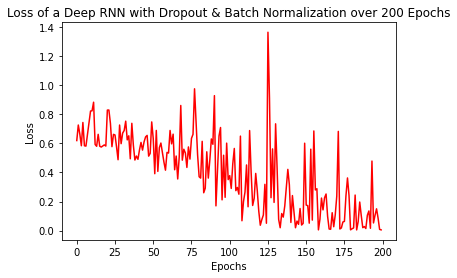

In [65]:
plt.plot(range(0,200), losses, color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss of a Deep RNN with Dropout & Batch Normalization over 200 Epochs')
plt.show()

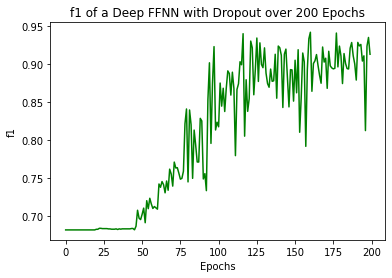

In [66]:
plt.plot(range(0,200), f1, color = 'green')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.title('f1 of a Deep FFNN with Dropout over 200 Epochs')
plt.show()

In [67]:
torch.save(model.state_dict(),'./drive/MyDrive/NLPproject/BatchNormFFNN')

In [68]:
class DeepRNN(nn.Module):
  def __init__(self,input_shape):
    super(DeepRNN,self).__init__()
    self.rnn1 = nn.RNN(input_shape, 32, 1, batch_first = True) 
    self.fc1 = nn.Linear(32, 64)
    self.rnn2 = nn.RNN(64, 128,1,batch_first = True)
    self.fc2 = nn.Linear(128,256)
    self.rnn3 = nn.RNN(256,512,1,batch_first = True)
    self.fc3 = nn.Linear(512, 1)
  
  def forward(self,x):
    hidden = self.init_hidden(1,32)
    hidden = hidden.to(device)
    x = torch.unsqueeze(x, dim = 0)
    x, _ = self.rnn1(x,hidden)
    x = x.contiguous().view(-1, 32)
    x = self.fc1(x)

    hidden = self.init_hidden(1,128)
    hidden = hidden.to(device)
    x = torch.unsqueeze(x, dim = 0)
    x, _ = self.rnn2(x,hidden)
    x = x.contiguous().view(-1, 128)
    x = self.fc2(x)

    hidden = self.init_hidden(1,512)
    hidden = hidden.to(device)
    x = torch.unsqueeze(x, dim = 0)
    x, _ = self.rnn3(x,hidden)
    x = x.contiguous().view(-1, 512)
    x = torch.sigmoid(self.fc3(x))
    return x, hidden 
  
  def init_hidden(self, batch_size, hidden_dim):
    hidden = torch.zeros(1,batch_size, hidden_dim)
    return hidden

In [69]:
learning_rate = 0.01
epochs = 200
# Model , Optimizer, Loss
model = DeepRNN(input_shape=x_test.shape[1])
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [70]:
losses = []
accur = []
f1 = []
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(trainset): 
    #calculate output
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    output, h = model(x_train)
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
    #accuracy
    predicted, h = model(x_test)
    comparer1 = predicted.cpu().reshape(-1).detach().numpy().round()
    comparer2 = y_test.cpu().numpy()
    true_pos = [v for v in range(len(comparer1)) if comparer1[v] == 1 and comparer1[v] == comparer2[v]]
    false_pos = [v for v in range(len(comparer1)) if comparer1[v] == 1 and comparer1[v] != comparer2[v]]
    false_neg = [v for v in range(len(comparer1)) if comparer1[v] == 0 and comparer1[v] != comparer2[v]]
    true_neg = [v for v in range(len(comparer1)) if comparer1[v] == 0 and comparer1[v] == comparer2[v]]
    acc = (len(true_pos) + len(true_neg))/(len(true_pos) + len(true_neg) + len(false_pos) + len(false_neg))
    recall = len(true_pos) /(len(true_pos) + len(false_pos))
    precision = len(true_pos) / (len(true_pos) + len(false_pos))
    f1_score = (2 * precision * recall) / (precision + recall)
    #backprop
    optimizer.zero_grad()
    loss.backward()
    loss.detach()
    x_train.detach()
    y_train.detach()
    optimizer.step()
  losses.append(loss.cpu().detach())
  accur.append(acc)
  f1.append(f1_score)
  if i % 50 == 0:
    print("epoch {}\tloss : {}\t accuracy : {} \t f1 score: {}".format(i,loss,acc,f1_score))

epoch 0	loss : 0.8172817230224609	 accuracy : 0.6816524908869988 	 f1 score: 0.6816524908869988
epoch 50	loss : 0.7702749967575073	 accuracy : 0.6780072904009721 	 f1 score: 0.6952506596306068
epoch 100	loss : 0.7047332525253296	 accuracy : 0.7047387606318347 	 f1 score: 0.7245762711864406
epoch 150	loss : 0.32804781198501587	 accuracy : 0.7266099635479951 	 f1 score: 0.8320158102766798


In [71]:
print('A Loss of {}, an Accuracy of {} and an f1 score of {} After 200 Epochs'.format(round(float(losses[-1]),3),round(accur[-1],3), round(f1[-1],3)))

A Loss of 0.434, an Accuracy of 0.778 and an f1 score of 0.794 After 200 Epochs


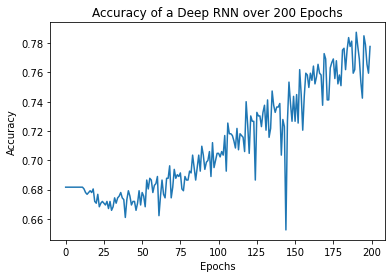

In [72]:
plt.plot(range(0,200), accur)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of a Deep RNN over 200 Epochs')
plt.show()

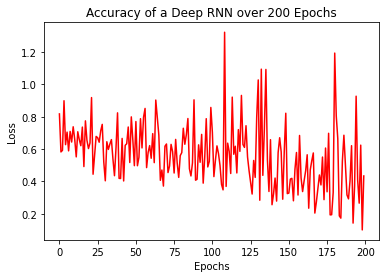

In [73]:
plt.plot(range(0,200), losses, color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Accuracy of a Deep RNN over 200 Epochs')
plt.show()

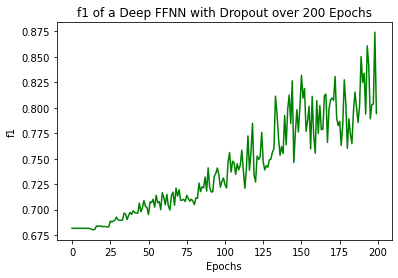

In [78]:
plt.plot(range(0,200), f1, color = 'green')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.title('f1 of a Deep FFNN with Dropout over 200 Epochs')
plt.show()

In [79]:
torch.save(model.state_dict(),'./drive/MyDrive/NLPproject/RNN')

In [80]:
class DeepDropoutRNN(nn.Module):
  def __init__(self,input_shape):
    super(DeepDropoutRNN,self).__init__()
    self.rnn1 = nn.RNN(input_shape, 32, 1, batch_first = True) 
    self.fc1 = nn.Linear(32, 64)
    self.rnn2 = nn.RNN(64, 128,1,batch_first = True)
    self.fc2 = nn.Linear(128,1)
    self.drop = nn.Dropout(0.01)
  
  def forward(self,x):
    hidden = self.init_hidden(1,32)
    x = torch.unsqueeze(x, dim = 0)
    hidden = hidden.to(device)
    x, hidden = self.rnn1(x,hidden)
    x = x.contiguous().view(-1, 32)
    x = self.fc1(x)

    hidden = self.init_hidden(1,128)
    x = torch.unsqueeze(x, dim = 0)
    hidden = hidden.to(device)
    x, hidden = self.rnn2(x,hidden)
    x = x.contiguous().view(-1, 128)
    x = self.drop(x)
    x = torch.sigmoid(self.fc2(x))

    return x, hidden 
  
  def init_hidden(self, batch_size, hidden_dim):
    hidden = torch.zeros(1,batch_size, hidden_dim)
    return hidden

In [89]:
learning_rate = 0.01
epochs = 200
# Model , Optimizer, Loss
model = DeepDropoutRNN(input_shape=x_test.shape[1])
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [90]:
losses = []
accur = []
f1 = []
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(trainset):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    #calculate output
    output, h = model(x_train)
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
    #accuracy
    predicted, h  = model(x_test)
    comparer1 = predicted.cpu().reshape(-1).detach().numpy().round()
    comparer2 = y_test.cpu().numpy()
    true_pos = [v for v in range(len(comparer1)) if comparer1[v] == 1 and comparer1[v] == comparer2[v]]
    false_pos = [v for v in range(len(comparer1)) if comparer1[v] == 1 and comparer1[v] != comparer2[v]]
    false_neg = [v for v in range(len(comparer1)) if comparer1[v] == 0 and comparer1[v] != comparer2[v]]
    true_neg = [v for v in range(len(comparer1)) if comparer1[v] == 0 and comparer1[v] == comparer2[v]]
    acc = (len(true_pos) + len(true_neg))/(len(true_pos) + len(true_neg) + len(false_pos) + len(false_neg))
    recall = len(true_pos) /(len(true_pos) + len(false_pos))
    precision = len(true_pos) / (len(true_pos) + len(false_pos))
    f1_score = (2 * precision * recall) / (precision + recall)
    #backprop
    optimizer.zero_grad()
    loss.backward()
    loss.detach()
    x_train.detach()
    y_train.detach()
    optimizer.step()
  losses.append(loss.cpu().detach())
  accur.append(acc)
  f1.append(f1_score)
  if i % 50 == 0:
    print("epoch {}\tloss : {}\t accuracy : {} \t f1 score: {}".format(i,loss,acc,f1_score))

epoch 0	loss : 0.6097584962844849	 accuracy : 0.6816524908869988 	 f1 score: 0.6816524908869988
epoch 50	loss : 0.5007060766220093	 accuracy : 0.6852976913730255 	 f1 score: 0.7091412742382271
epoch 100	loss : 0.45894116163253784	 accuracy : 0.7023086269744836 	 f1 score: 0.7438271604938271
epoch 150	loss : 0.30566805601119995	 accuracy : 0.74726609963548 	 f1 score: 0.7753510140405617


In [91]:
print('A Loss of {}, an Accuracy of {} and an f1 score of {} After 200 Epochs'.format(round(float(losses[-1]),3),round(accur[-1],3), round(f1[-1],3)))

A Loss of 0.407, an Accuracy of 0.796 and an f1 score of 0.816 After 200 Epochs


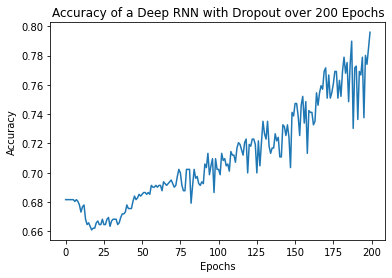

In [92]:
plt.plot(range(0,200), accur)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of a Deep RNN with Dropout over 200 Epochs')
plt.show()

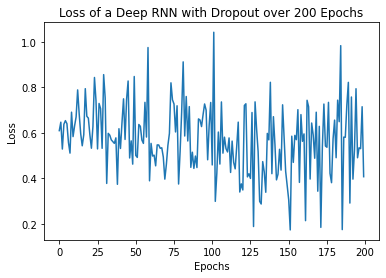

In [93]:
plt.plot(range(0,200), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss of a Deep RNN with Dropout over 200 Epochs')
plt.show()

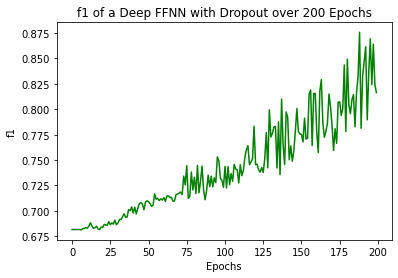

In [94]:
plt.plot(range(0,200), f1, color = 'green')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.title('f1 of a Deep FFNN with Dropout over 200 Epochs')
plt.show()

In [95]:
torch.save(model.state_dict(),'./drive/MyDrive/NLPproject/DropoutRNN')

In [96]:
class DeepBatchNormRNN(nn.Module):
  def __init__(self,input_shape):
    super(DeepBatchNormRNN,self).__init__()
    self.rnn1 = nn.RNN(input_shape, 32, 1, batch_first = True) 
    self.fc1 = nn.Linear(32, 64)
    self.b1 = nn.BatchNorm1d(64)
    self.rnn2 = nn.RNN(64, 128,1,batch_first = True)
    self.fc2 = nn.Linear(128,256)
    self.b2 = nn.BatchNorm1d(256)
    self.rnn3 = nn.RNN(256,512, 1, batch_first = True)
    self.b3 = nn.BatchNorm1d(512)
    self.fc3 = nn.Linear(512, 1)
    self.drop = nn.Dropout(0.01)
  
  def forward(self,x):
    hidden = self.init_hidden(1,32)
    x = torch.unsqueeze(x, dim = 0)
    hidden = hidden.to(device)
    x, hidden = self.rnn1(x,hidden)
    x = x.contiguous().view(-1, 32)
    x = self.fc1(x)
    x = self.b1(x)

    hidden = self.init_hidden(1,128)
    x = torch.unsqueeze(x, dim = 0)
    hidden = hidden.to(device)
    x, hidden = self.rnn2(x,hidden)
    x = x.contiguous().view(-1, 128)
    x = self.fc2(x)
    x = self.b2(x)
    
    hidden = self.init_hidden(1,512)
    x = torch.unsqueeze(x, dim = 0)
    hidden = hidden.to(device)
    x, hidden = self.rnn3(x,hidden)
    x = x.contiguous().view(-1, 512)
    x = self.b3(x)
    x = self.drop(x)
    x = torch.sigmoid(self.fc3(x))

    return x, hidden 
  
  def init_hidden(self, batch_size, hidden_dim):
    hidden = torch.zeros(1,batch_size, hidden_dim)
    return hidden

In [97]:
learning_rate = 0.01
epochs = 200
# Model , Optimizer, Loss
model = DeepBatchNormRNN(input_shape=x_test.shape[1])
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [98]:
losses = []
accur = []
f1 = []
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(trainset):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    #calculate output
    output, h = model(x_train)
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
    #accuracy
    predicted, h = model(x_test)
    comparer1 = predicted.cpu().reshape(-1).detach().numpy().round()
    comparer2 = y_test.cpu().numpy()
    true_pos = [v for v in range(len(comparer1)) if comparer1[v] == 1 and comparer1[v] == comparer2[v]]
    false_pos = [v for v in range(len(comparer1)) if comparer1[v] == 1 and comparer1[v] != comparer2[v]]
    false_neg = [v for v in range(len(comparer1)) if comparer1[v] == 0 and comparer1[v] != comparer2[v]]
    true_neg = [v for v in range(len(comparer1)) if comparer1[v] == 0 and comparer1[v] == comparer2[v]]
    acc = (len(true_pos) + len(true_neg))/(len(true_pos) + len(true_neg) + len(false_pos) + len(false_neg))
    recall = len(true_pos) /(len(true_pos) + len(false_pos))
    precision = len(true_pos) / (len(true_pos) + len(false_pos))
    f1_score = (2 * precision * recall) / (precision + recall)
    #backprop
    optimizer.zero_grad()
    loss.backward()
    loss.detach()
    x_train.detach()
    y_train.detach()
    optimizer.step()
  losses.append(loss.cpu().detach())
  accur.append(acc)
  f1.append(f1_score)
  if i % 50 == 0:
    print("epoch {}\tloss : {}\t accuracy : {} \t f1 score: {}".format(i,loss,acc,f1_score))

epoch 0	loss : 0.7426565885543823	 accuracy : 0.5978128797083839 	 f1 score: 0.701048951048951
epoch 50	loss : 0.5770261287689209	 accuracy : 0.6986634264884569 	 f1 score: 0.7232524964336662
epoch 100	loss : 0.3433986306190491	 accuracy : 0.7509113001215066 	 f1 score: 0.7861736334405146
epoch 150	loss : 0.19194573163986206	 accuracy : 0.8080194410692588 	 f1 score: 0.8409475465313029


In [99]:
print('A Loss of {}, an Accuracy of {} and an f1 score of {} After 200 Epochs'.format(round(float(losses[-1]),3),round(accur[-1],3), round(f1[-1],3)))

A Loss of 0.094, an Accuracy of 0.832 and an f1 score of 0.88 After 200 Epochs


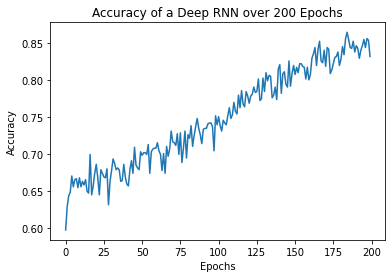

In [100]:
plt.plot(range(0,200), accur)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of a Deep RNN over 200 Epochs')
plt.show()

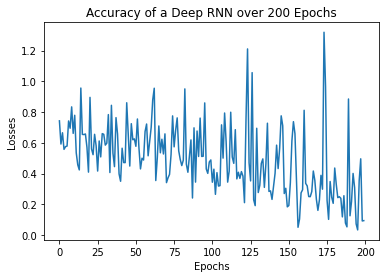

In [101]:
plt.plot(range(0,200), losses)
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Accuracy of a Deep RNN over 200 Epochs')
plt.show()

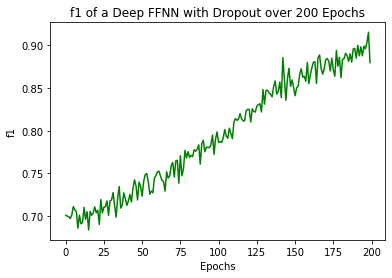

In [102]:
plt.plot(range(0,200), f1, color = 'green')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.title('f1 of a Deep FFNN with Dropout over 200 Epochs')
plt.show()

In [103]:
torch.save(model.state_dict(),'./drive/MyDrive/NLPproject/BatchNormRNN')

In [ ]:
import random

def predict_song(model):
  ind = random.randrange(0,len(x_test))
 # print(X[ind])
  
  predict,_ = model(x_test)
  print('happy' if predict[ind][0] > 0.5 else 'sad' ,'happy' if y_test[ind] == 1 else 'sad')

In [ ]:
torch.load('./drive/MyDrive/')
predict_song(model)

happy happy
